In [1]:
## Data At: http://thumbnailpacks.libretro.com/

## Try doing a few things to improve GAN perforamnce: 
### -- schedule a change in learning rate as D(x) gets stronger at differentiating real from fake. We note that
### some significant development happened when we sampled D(x) for the 80th time. 
### -- consider noising the input data to challenge the discriminator. 
### -- consider occasionally flipping the real/fake image targets for the discriminator to "confuse" it, 
### essentially to handicap its abilities. 
### -- introduce regularization into the discriminator via dropout or a regularization term to the discriminator's loss
### -- schedule change in learning rates as you go into later epochs (turning down learning rate)

## "performance" may be defined by: 
### -- the stability of D(x) and D(G(z)) ~ 0.5
### -- a decreasing to stable loss of the discriminator and generator
### -- a batch of images that are subjectively "better" looking at earlier epochs

### Also try to increase the size of the generated images to 96x96 and 128x128. This can be done by adjusting the stride
### or kernel sizes of the generator. One can go from 64 -> 128 simply by adding another deconv layer with similar 
### parameters as the previous ones used. 
#### Note that you will need to adjust the discriminator accordingly. It is a CNN that expects to operate on a 64x64
#### image; you will need to adjust the CNN parameters so that the CNN layers will output a 1x1 volume prior to the 
#### sigmoid at the end.

%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from timeit import default_timer as timer

## This is a custom imshow function that undo's the normalization pytorch does when I load the data in.
def imshow(img):
    img = img / 2 + 0.5 #un-normalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))


In [10]:
t = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])  

batch_size = 16
dset = dsets.ImageFolder("/home/derek/atrc18/data/nes/", transform=t)
data_loader = torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=True, num_workers=6)
print(len(data_loader))
174*16

174


2784

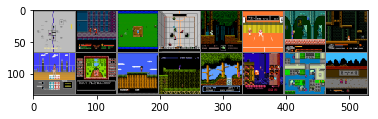

In [11]:
for i, images in enumerate(data_loader):
     images, _ = images
     imshow(torchvision.utils.make_grid(images))
     break
plt.show()

In [12]:
zdim = 100
class GNet(nn.Module):
    def __init__(self):
        super(GNet, self).__init__()

        
        ##input size: batch_size x zdim x 1 x 1
        self.convt1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=zdim, out_channels=128 * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128 * 8),
            nn.ReLU(True))
        ##output size: batch_size x 128*8 x 4 x 4

        self.convt2 = nn.Sequential(
            nn.ConvTranspose2d(128 * 8, 128 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128 * 4),
            nn.ReLU(True))
        #output size: batch_size x 128*4 x 8 x 8
        
        self.convt3 = nn.Sequential(
            nn.ConvTranspose2d(128 * 4, 128 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128 * 2),
            nn.ReLU(True))
        #output size: batch_size x 128*2 x 16 x 16
        
        self.convt4 = nn.Sequential(
            nn.ConvTranspose2d(128 * 2, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True))
        #output size: batch_size x 128 x 32 x 32

        self.out_layer = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),  
            nn.Tanh())
         #output size: batch_size x 3 x 64 x 64

    def forward(self, input):
        x = self.convt1(input)
        x = self.convt2(x)
        x = self.convt3(x)
        x = self.convt4(x)
        return self.out_layer(x)

###
class DNet(nn.Module):
    def __init__(self):
        super(DNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True))

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 2),
            nn.LeakyReLU(0.2, True))

        self.conv3 = nn.Sequential(
            nn.Conv2d(32 * 2, 32 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 4),
            nn.LeakyReLU(0.2, True))

        self.conv4 = nn.Sequential(
            nn.Conv2d(32 * 4, 32 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 8),
            nn.LeakyReLU(0.2, True))

        # the output layer will just emit D(x), the probability the input is a real image.
        self.out_layer = nn.Sequential(
            nn.Conv2d(32 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.out_layer(x)
        #squeeze just returns a tensor where all dimensions of size 1 are removed.
        return x.view(-1, 1).squeeze(1)

In [13]:
G = GNet()
D = DNet()
G.cuda()
D.cuda()

loss_function = nn.BCELoss()

g_learning_rate = 0.002
d_learning_rate = 0.001
optimizer_G = torch.optim.Adam(G.parameters(), lr=g_learning_rate, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=d_learning_rate, betas=(0.5,0.999))

In [15]:
test_images = Variable(torch.FloatTensor(32, zdim, 1, 1).normal_(0,1)).cuda()

loss_D = [] ##loss of the discriminator
loss_G = [] ##loss of generator
Dx = [] ##output of discriminator on real
Dgz = [] ##output of disciminator on fake before G weight update
Dg = [] ##ouput of disciminator on fake after G weight update

num_epochs = 50
for epoch in xrange(num_epochs):
    for batch_index, batch in enumerate(data_loader):
        
        ### Train the discriminator
        D.zero_grad()
        
        real_imgs = Variable(batch[0]).cuda()
        this_batch_size = batch[0].shape[0]
        output = D(real_imgs)
        target_real = Variable(torch.FloatTensor(this_batch_size).fill_(0.9)).cuda()
        d_loss_real = loss_function(output,target_real)
        
        d_loss_real.backward()
        
        noise_vectors = Variable(torch.FloatTensor(this_batch_size, zdim, 1, 1).normal_(0,1)).cuda()
        fake_imgs = G(noise_vectors)
        target_fake = Variable(torch.FloatTensor(this_batch_size).fill_(0)).cuda()
        output = D(fake_imgs)
        d_loss_fake = loss_function(output,target_fake)
        
        d_loss_fake.backward()
        
        optimizer_D.step()
        
        if batch_index % 85 == 0:
            output = D(real_imgs)
            Dx.append(output.data.cpu().mean())
            d_loss_real = loss_function(output,target_real)

            output = D(fake_imgs)
            d_loss_fake = loss_function(output,target_fake)
            loss_D.append(d_loss_real.data.cpu()+d_loss_fake.data.cpu())
        
        ### Train the generator
        G.zero_grad()
        
        noise_vectors = Variable(torch.FloatTensor(batch_size, zdim, 1, 1).normal_(0,1)).cuda()
        fake_imgs = G(noise_vectors)
        output = D(fake_imgs)

        if batch_index % 85 == 0:
            Dgz.append(output.data.cpu().mean())
        
        target_real = Variable(torch.FloatTensor(batch_size).fill_(0.9)).cuda()
        g_loss = loss_function(output,target_real)
        
        g_loss.backward()
        
        optimizer_G.step()
        
        if batch_index % 85 == 0:
            fake_imgs = G(noise_vectors)
            output = D(fake_imgs)
            g_loss = loss_function(output,target_real)
            Dg.append(output.data.cpu().mean())
            loss_G.append(g_loss.data.cpu())
    
    print("Epoch: [%i/%i], loss_D: %.4f, loss_G: %.4f, D(x): %.4f, D(G(z)) Pre: %.4f / Post: %.4f" % 
          (epoch, num_epochs, loss_D[-1], loss_G[-1], Dx[-1], Dgz[-1], Dg[-1]))
    
    # Save new images generated by g.
    fake = G(test_images)
    torchvision.utils.save_image(fake.data,
      os.getcwd() + '/data/gen-nes/fake_samples_epoch_%03d.png' % (epoch),
      normalize=True)
        
        

Epoch: [0/50], loss_D: 0.7404, loss_G: 1.8230, D(x): 0.6516, D(G(z)) Pre: 0.1827 / Post: 0.1573
Epoch: [1/50], loss_D: 0.9945, loss_G: 1.0360, D(x): 0.5289, D(G(z)) Pre: 0.2676 / Post: 0.3489
Epoch: [2/50], loss_D: 1.0453, loss_G: 2.6085, D(x): 0.4052, D(G(z)) Pre: 0.0792 / Post: 0.0618
Epoch: [3/50], loss_D: 0.9343, loss_G: 0.8576, D(x): 0.5637, D(G(z)) Pre: 0.2689 / Post: 0.4346
Epoch: [4/50], loss_D: 0.9363, loss_G: 1.4654, D(x): 0.5115, D(G(z)) Pre: 0.1911 / Post: 0.2097
Epoch: [5/50], loss_D: 0.7859, loss_G: 1.2519, D(x): 0.6175, D(G(z)) Pre: 0.1972 / Post: 0.2740
Epoch: [6/50], loss_D: 0.7795, loss_G: 1.3179, D(x): 0.6249, D(G(z)) Pre: 0.1917 / Post: 0.2903
Epoch: [7/50], loss_D: 0.7442, loss_G: 1.3792, D(x): 0.6318, D(G(z)) Pre: 0.1802 / Post: 0.2376
Epoch: [8/50], loss_D: 0.8336, loss_G: 1.2658, D(x): 0.6371, D(G(z)) Pre: 0.2538 / Post: 0.2978
Epoch: [9/50], loss_D: 0.8585, loss_G: 1.3735, D(x): 0.5682, D(G(z)) Pre: 0.1961 / Post: 0.2512
Epoch: [10/50], loss_D: 0.8711, loss_G: 

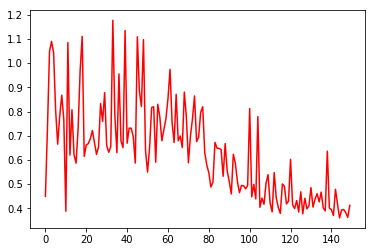

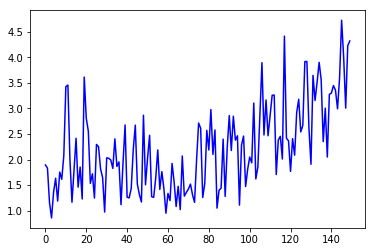

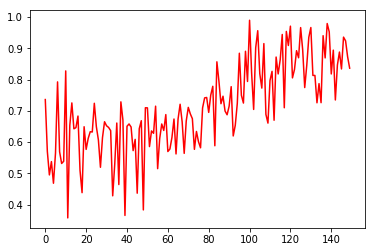

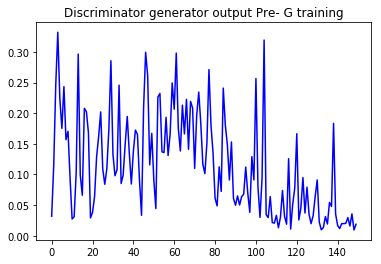

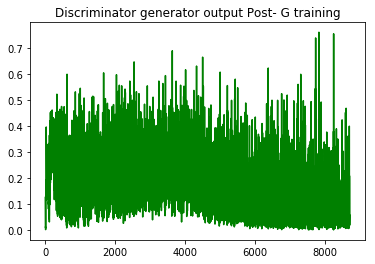

In [12]:
fig = plt.figure()
plt.plot(np.arange(0,len(loss_D)),loss_D,color="red")
plt.show()
plt.plot(np.arange(0,len(loss_G)),loss_G, color="blue")
plt.show()
plt.plot(np.arange(0,len(Dx)),Dx, color="red")
plt.show()
plt.title("Discriminator generator output Pre- G training")
plt.plot(np.arange(0,len(Dgz)),Dgz, color="blue")
plt.show()
plt.title("Discriminator generator output Post- G training")
plt.plot(np.arange(0,len(Dg)),Dg, color="green")
plt.show()